Set Up

In [577]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
# Standard libraries
import logging
import os
import pathlib
import sys

# 3rd party libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import pandera as pa
from pandera import Hypothesis
import functools

# Local libraries
import pudl
import pudl.constants as pc
import pudl.validate as pv

In [20]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [21]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine) # freq='monthly'/'annual' (maybe other abr.)

In [22]:
#only load when you need to, takes a while
bf_eia923 = pudl_out.bf_eia923()

Function to create plot

In [204]:
# Function to display weighted distribution
def finite_distplot(df, data_col, wt_col=None, nbins=100, max_val=np.infty):
    """
    Plot weighted distribution of values less than a maximum value.
    
    Args:
        df (pandas.DataFrame): The dataframe containing the data and
            weights to plot.
        data_col (str): Label of the column containing the data.
        wt_col (str or None): Label of the column to use to weight the data.
            If None (the default) data is not weighted.
        nbins (int): Number of histogram bins to use.
        max_val (float): Maximum data value to allow in data visualized.
    
    Returns:
        None
    
    """
    df = df[df[data_col] < max_val]
    weights = None
    if wt_col is not None:
        weights = df[wt_col]
    _ = sns.distplot(df[data_col], bins=nbins, hist_kws={"weights": weights})

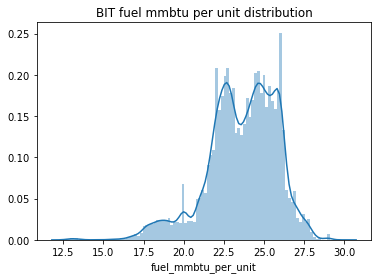

In [578]:
# Show weighted distribution of columns 

bit_df = bf_eia923[(
    (bf_eia923['fuel_type_code']=='BIT') 
    & (bf_eia923['fuel_mmbtu_per_unit']!= 0)
)]

bit_ax = finite_distplot(bit_df, "fuel_mmbtu_per_unit",)#wt_col="fuel_consumed_units")
plt.title("BIT fuel mmbtu per unit distribution");

Sample Data

In [205]:
# SAMPLE data

df = pd.DataFrame({
    "report_year": [2010, 2011, 2012, 2010, 2011, 2012],
    "plant_id_eia": [1, 1, 1, 2, 2, 2],
    "fuel_consumed_units": [5668.0, 8925.0, 6665.0, 623561.0, 675227.0, 574865.0],
    "fuel_mmbtu_per_unit": [22.496, 22.710, 22.798, 1.032, 1.032, 1.032],
    "fuel_type_code": ['BIT', 'BIT', 'BIT', 'NG', 'NG', 'NG'],
})

In [432]:
# Test dictionaries

d = {'BIT': 25, 'NG':2}
d2 = {'BIT': df.query("fuel_type_code=='BIT'")['fuel_mmbtu_per_unit'], 
      'NG': df.query("fuel_type_code=='NG'")['fuel_mmbtu_per_unit']}

**Questions about Niels' email**:
* meaning of groups: Dict[str, pd.Series] and why it isn't referenced in the arguments where the function is called
* *make_percentile_value_checks() and why there is an asterisk before the function

Iteration Examples

In [557]:
# you can use print statements to see results not in list form

# example tuples and lists
li = [1,2,3,4]
lii = (1,2,3,4)
liii = [(1,2,3,4)]
lip = [(1,2), (3,4)]
lid = ((1,2), (3,4))
liz = [(1,2,3)]
lit = [(1), (2), (3)]

# partial example (pauses a function with a specific argument pre-specified)
def test1(x):
    return x + 1
# RUN:
# wait = partial(test1, 2)  # as compared to lambda x: x+1 (both are same type)
# wait()  # this will run the function with the agrument of 2.

# reduce example (iterates over many inputs, continually adding them to the function...bad descrip)
def test2(x, y):
    return x + y
# RUN: 
#functools.reduce(test2, li)

# cool return example
def run_tests():
    return [
        test1(x)
        for x in li
    ]

# tuple unpacking examples
def run_tests_2(tups): # best to use lip as an argument
    return [
        test2(*tup)
        for tup in tups
    ]
def run_tests_1(listt): # best to use any pure list as an argument
    return [
        test1(item)
        for item in listt
    ]

# Mapping arguments to functions also unpacking tuples
t1 = map(test1, li)
t2 = map(test2, *lid)
#print(list(t1))
#print(list(t2))

In [ ]:
iterate_dict(d2)

In [281]:
# Using PARTIAL in the pandera pa.Check() to mimic lambda x
wait = partial(test, 2)
#wait()

Dictionary Iterator

In [258]:
# This function iterates through the dictionary created in the 
# pa.Check(lambda s: XXX, groupby=X) -- when a groupby is specified, the s in lambda
# s becomes a dictionary where the key is the value in the column you grouped by (in
# this case BIT/NG and the value is the part of the column that pertains to that key value).
# This function loops through that dictionary and runs a test on each different section of column.
# In the future, you can have links to a CSV. It DOES NOT reference other columns, however.

def iterate_through_fuel_dict(df_by_fuel_dict):
    test=False
    for fuel, col in df_by_fuel_dict.items():
        if col.mean() < d[fuel]:
            raise ValueError(f'{fuel} columns out of line')
        else:
            test=True
    return test

# Recreate function above with new knowledge -- does not work because output is a list

def iterate_dict(df_by_fuel_dict):
    return [
        col.mean() > d[fuel]
        for fuel, col in df_by_fuel_dict.items()
    ]

In [531]:
# Quantile tests
ser = pd.Series([1,2,3,4,5])
#ser.quantile(0.05)

Niels's function with high and low bounds:

In [535]:
# Niels's function with high and low bounds
# NOTE: NO WEIGHTED COLS in these examples

from typing import Dict

# example meta data storage
percentile_values = {
    "BIT": [{"lo_ptile": 0.05, "lo_bound": 17.0, "hi_ptile": 0.95, "hi_bound": 30.0}],
    "NG": [{"lo_ptile": 0.05, "lo_bound": 0.95, "hi_ptile": 0.95, "hi_bound": 1.15}]
}

def make_lo_bound_checks(percentile_values, groupby):
    """Programmatically create all checks for low bounds."""

    def check_lo_bound(fuel_type, lo_ptile, lo_bound, groups: Dict[str, pd.Series]): 
        """Check that a given percent of the data is above the given low bound."""
        logger.info(f"Running low bound tests for {fuel_type}")
        return groups[fuel_type].quantile(lo_ptile) > lo_bound
        
    return [
        pa.Check(
            partial(check_lo_bound, fuel_type, x["lo_ptile"], x["lo_bound"]),
            groupby=groupby,
            error=(
                f"check for group '{fuel_type}' failed for low bound "
                f"{x['lo_ptile']} with industry standard value {x['lo_bound']}"
            ),
        )
        for fuel_type, ptile_values in percentile_values.items()
        for x in ptile_values
    ]

def make_hi_bound_checks(percentile_values, groupby):
    """Programmatically create all checks for high bounds"""
    
    def check_hi_bound(fuel_type, hi_ptile, hi_bound, groups: Dict[str, pd.Series]):
        """Check that a given percent of the data is below the given high bound."""
        logger.info(f"Running high bound tests for {fuel_type}")
        return groups[fuel_type].quantile(hi_ptile) < hi_bound
    
    return [
        pa.Check(
            partial(check_hi_bound, fuel_type, x["hi_ptile"], x["hi_bound"]),
            groupby=groupby,
            error=(
                f"check for group '{fuel_type}' failed for low bound "
                f"{x['lo_ptile']} with industry standard value {x['lo_bound']}"
            ),
        )
        for fuel_type, ptile_values in percentile_values.items()
        for x in ptile_values
    ]
    

Niels's function with layered percentile value structure:

In [519]:
# Niels's function with layered percentile value structure

from typing import Dict

# example meta data
pt_values = {
    "BIT": {"low": [{"ptile": 0.05, "value": 17.0}], 
             "high": [{"ptile": 0.95, "value": 30.0}]
            },
    "NG": {"high": [{"ptile": 0.05, "value": 0.95}],
            "low": [{"ptile": 0.95, "value": 1.15}]
           },
}

# function to programatically create check
def make_bounds_checks(percentile_values, groupby):
    """Programmatically create checks for low and high bounds."""

    def check_bound(fuel_type, bound, ptile, value, groups: Dict[str, pd.Series]): 
        """Check that a given percent of the data is above or below the given bound."""
        #groups[group].quantile(lo_ptile) > lo_bound
        if bound == "low":
            test = groups[fuel_type].quantile(ptile) > value
        if bound == "high":
            test = groups[fuel_type].quantile(ptile) < value
        return test
        
    return [
        pa.Check(
            partial(check_bound, bound, x["ptile"], x["value"]),
            groupby=groupby,
            error=(
                f"check for group '{fuel_type}' failed for {bound} bound "
                f"{x['ptile']} with industry standard value {x['value']}"
            ),
        )
        for fuel_type, bound_values in pt_values.items()
        for bound, ptiles in bound_values.items()
        for x in ptiles
    ]

Test Schema

In [536]:
# Good Test Schema

schema_bf_923 = pa.DataFrameSchema({
    "fuel_type_code": pa.Column(
        pa.String, 
        pa.Check(lambda s: s.isin(['BIT', 'NG']))),
    "fuel_mmbtu_per_unit": pa.Column(
        pa.Float, 
        checks=[
            #*make_bounds_checks(pt_values, "fuel_type_code")
            *make_lo_bound_checks(percentile_values, "fuel_type_code"),
            *make_hi_bound_checks(percentile_values, "fuel_type_code"),
        ],
        nullable=True)
}, #checks=[
    #pa.Check(lambda df: (
    #    test_bounds(df, df.fuel_mmbtu_per_unit, fuel='BIT',high=26.5, low=20.5))),
#     pa.Check(lambda df: (
#         test_bounds(df, 'fuel_mmbtu_per_unit', fuel='NG', high=1.036, low=1.018)))
#])
)

In [537]:
schema_bf_923.validate(df)

Running low bound tests for BIT
Running low bound tests for NG
Running high bound tests for BIT
Running high bound tests for NG


,report_year,plant_id_eia,fuel_consumed_units,fuel_mmbtu_per_unit,fuel_type_code
0,2010,1,5668.0,22.496,BIT
1,2011,1,8925.0,22.710,BIT
2,2012,1,6665.0,22.798,BIT
3,2010,2,623561.0,1.032,NG
4,2011,2,675227.0,1.032,NG
5,2012,2,574865.0,1.032,NG
